In [1]:
import autograd.numpy as np

# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook
%matplotlib inline
# autoreload functi"on - so if anything behind the scenes is changeed those changes
# are reflected in the notebook without having to restart the kernel
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import autograd.numpy as np
import matplotlib.pyplot as plt
from autograd import grad
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image

# import function flattening module from autograd
from autograd.misc.flatten import flatten_func

In [3]:
# load in ford stock data
data = np.loadtxt('../data/ford_close.csv',delimiter = ',')

In [4]:
actions = []
states = []

# for i in range(1,len(data)):
#     actions.append(np.array(data[0:i]))
for i in data[0:len(data)-2]:
    actions.append(np.array(i))
for i in data[1:]:
    states.append(np.array(i))

actions = np.array([np.array(actions)])
states = np.array([np.array(states)])


In [37]:
# A simple (order 1 MDP, linear) system model implementation
def system_model(s_t,a_t,w):
    return w[0] + w[1]*s_t + w[2]*a_t

# loop for evaluating system_model over all input/output action/state pairs
def system_loop(w,a,s):
    # compute least squares over all system model outputs at once
    s_predict = [s[:,0]]  # container for system_model state outputs
    for t in range(a.shape[1]):
        # get current action-state pair
        a_t = a[:,t]
        s_t = s[:,t]
        
        # feed into system_model to get predicted output
        s_hat = system_model(s_t,a_t,w)
        
        # store prediction
        s_predict.append(s_hat)
        
    # array-afy predictions and return
    return np.array(s_predict).T

# an implementation of the least squares cost for system identification
# note here: s is an (1 x T) array and a an (1 x T-1) array
def least_squares(w,a,s):
    # system_loop - runs over all action-state pairs and produces entire
    # state prediction set
    s_predict = system_loop(w,a,s)
    
#     print(s_predict.shape)
#     print(s.shape)

    # compute least squares error between real and predicted states
    cost = np.sum((s_predict[:,1:] - s[:,1:])**2)
    return cost/float(s.shape[1]-1)

def least_squares2(w,a,s):
    # system_loop - runs over all action-state pairs and produces entire
    # state prediction set
    s_predict = system_loop(w,a,s)

    # compute least squares error between real and predicted states
    cost = np.sum((s_predict[:,1:] - s[:,1:])**2)
    
    g, unflatten_func, w = flatten_func(g, w)
    
    return cost/float(s.shape[1]-1)


def gradient_descent(g,alpha,max_its,w): 
    # compute gradient module using autograd
    gradient = grad(g)

    # run the gradient descent loop
    weight_history = [w] # weight history container
#    cost_history = [g(w)] # cost function history container
    cost_history = [g(w,actions,states)]
    for k in range(max_its):
        # evaluate the gradient
        #grad_eval = gradient(w)
        grad_eval = gradient(w,actions,states)

        # take gradient descent step
        w = w - alpha*grad_eval
        
        # record weight and cost
        weight_history.append(w)
#        cost_history.append(g(w))
        cost_history.append(g(w,actions,states))
    return weight_history,cost_history

In [38]:
# zero order coordinate search
def coordinate_descent_zero_order(g,alpha_choice,max_its,w):  
    # run coordinate search
    N = np.size(w)
    weight_history = []         # container for weight history
    cost_history = []           # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):        
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        # random shuffle of coordinates
        c = np.random.permutation(N)
        
        # forming the dirction matrix out of the loop
        DIRECTION = np.eye(N)
        cost = g(w, actions, states)
#         print(cost.shape)
        
        # loop over each coordinate direction
        for n in range(N):
            #direction = np.zeros((N,1))
            #direction[c[n]] = 1
            direction = DIRECTION[:,[c[n]]]
     
            # record weights and cost evaluation
            weight_history.append(w)
            cost_history.append(cost)

            # evaluate all candidates
            evals =  [g(w + alpha*direction,actions,states)]
            evals.append(g(w - alpha*direction,actions,states))
            evals = np.array(evals)

            # if we find a real descent direction take the step in its direction
            ind = np.argmin(evals)
            if evals[ind] < cost_history[-1]:
                # take step
                w = w + ((-1)**(ind))*alpha*direction
                cost = evals[ind]
        
    # record weights and cost evaluation
    weight_history.append(w)
    cost_history.append(g(w, actions, states))
    return weight_history,cost_history

In [39]:
g=least_squares;

# g = lambda w: np.tanh(4*w[0]+4*w[1])+max(.4*(w[0]**2),1)+1;

w = 0.1*np.random.randn(3,1);

# flatten an input function g
#g, unflatten_func, w = flatten_func(g, w)

# k=300; alph = .0001;
k=300; alph = 'diminishing';
# weight_history_1,cost_history_1 = gradient_descent(g,alph,k,w)
weight_history_1,cost_history_1 = coordinate_descent_zero_order(g,alph,k,w)


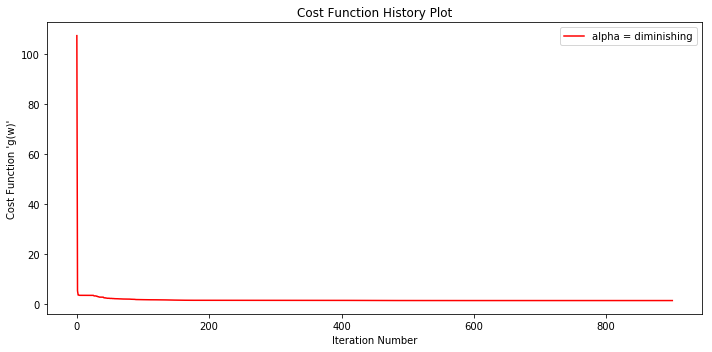

In [40]:
fig = plt.figure(figsize=(10,5))
plt.plot(range(len(cost_history_1)),cost_history_1,c='red',label='alpha = '+str(alph))
plt.legend(loc='upper right')
plt.title("Cost Function History Plot")
plt.xlabel("Iteration Number")
plt.ylabel("Cost Function 'g(w)'")
plt.show()

In [41]:
#generate prediction line
bestw=weight_history_1[-1]
print(bestw)
line1 = [system_model(s,a,bestw) for s,a in zip(states[0],actions[0])]

[[0.15607818]
 [0.73828907]
 [0.2475253 ]]


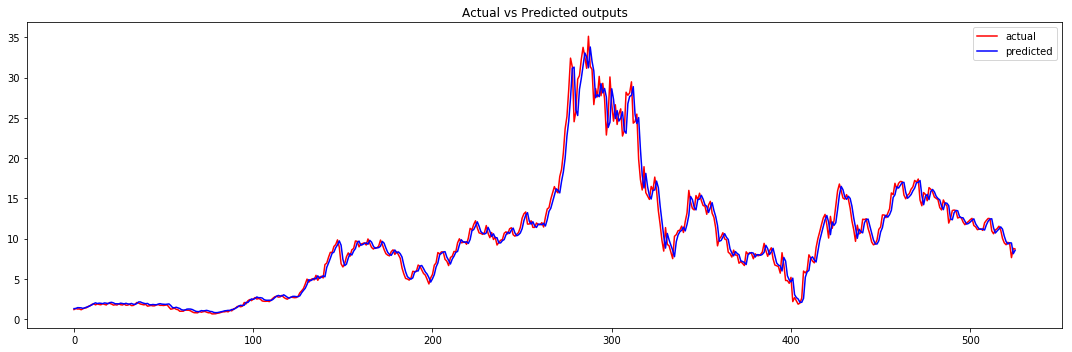

In [42]:
fig = plt.figure(figsize=(15,5))
plt.plot(range(len(states[0])-1),states[0][1:],c='red',label='actual')
plt.plot(range(len(line1)),line1,c='blue',label='predicted')
plt.legend(loc='upper right')
plt.title("Actual vs Predicted outputs")
plt.show()